# **Google Drive Mount**

Run this cell if yourdataset is inn your google drive or you want to save the trained models to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Imports and Installs**

In [2]:

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, Subset, random_split, Dataset
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import time
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
!pip install kornia
import kornia.augmentation as K
from kornia.augmentation import AugmentationSequential
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


# **Globals**

Detailed dataset Information and  download can be found [here](https://www.kaggle.com/datasets/mohnishsaiprasad/forest-fire-images)

> Add blockquote



In [3]:
# Set the dataset root directory
dataset_root = "/content/drive/MyDrive/Computer_Vision_Project/fire_data/"
# Set the saved_models directory
saved_models_path = "/content/drive/MyDrive/Computer_Vision_Project/saved_models"

# **Data Preproccess**

Dataset Class

In [4]:
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(idx)

        data = list(zip(self.image_paths, self.labels))
        random.shuffle(data)
        subset_size = int(len(data) * 1)
        data = data[:subset_size]

        self.image_paths, self.labels = zip(*data)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:

IMAGE_SIZE = 256
batch_size = 128

Transformations, Train-Validation-Test Split, Device

In [6]:

transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])


# Create the dataset
dataset = FireDataset(root_dir=dataset_root, transform=transform)

# Calculate split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print the number of samples
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Check device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

Number of training samples: 3227
Number of validation samples: 691
Number of test samples: 692
device = cuda:0


# **Data Visualization**

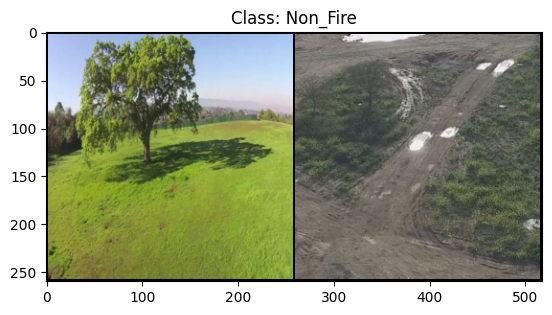

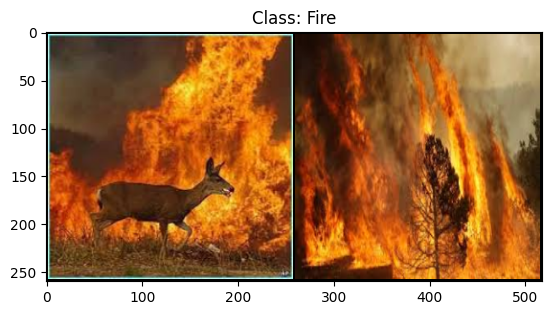

In [9]:
# 2 samples of each class
def imshow(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

class_names = dataset.classes
samples_per_class = 2
samples = {class_name: [] for class_name in class_names}

for img, label in train_dataset:
    class_name = class_names[label]
    if len(samples[class_name]) < samples_per_class:
        samples[class_name].append(img)
    if all(len(samples[class_name]) == samples_per_class for class_name in class_names):
        break

for class_name, imgs in samples.items():
    imshow(make_grid(imgs, nrow=samples_per_class), title=f"Class: {class_name}")

# **General functions and utils**

In [10]:
def calculate_accuracy(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
    model_accuracy = total_correct / total_images * 100
    return model_accuracy

In [11]:
def plot_normalized_confusion_matrix_from_model(model):
    """
    Generates and plots a normalized confusion matrix for a given model.

    Parameters:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset to evaluate.
        device (torch.device): The device to perform computations on (CPU or CUDA).
        class_names (list): List of class names corresponding to the target labels.

    Returns:
        None: The function directly displays the confusion matrix plot.
    """

    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    class_names = ['Fire', 'No Fire']
    num_classes = 2

    # Generate predictions for the data
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Normalize the confusion matrix by dividing by the sum of each row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Visualize the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Normalized Confusion Matrix')
    plt.show()


In [12]:
def plot_training_stats(epochs, losses, train_scores, val_scores):
  fig, axs = plt.subplots(1, 3, figsize=(20, 5))

  epochs_axis = list(range(0, epochs+1, 2))

  axs[0].plot(epochs_axis, losses)
  axs[1].plot(epochs_axis, train_scores)
  axs[2].plot(epochs_axis, val_scores)

  axs[0].set_title('Loss Curve')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Loss')

  axs[1].set_title('Training Accuracy')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Accuracy')

  axs[2].set_title('Validation Accuracy')
  axs[2].set_xlabel('Epochs')
  axs[2].set_ylabel('Accuracy')

  plt.tight_layout()
  plt.show()

In [13]:
def calc_model_size_and_params(model):
  num_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  print("num trainable weights: ", num_trainable_params)
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()
  size_all_mb = (param_size + buffer_size) / 1024 ** 2
  print(f"model size: {size_all_mb:.2f} MB")

In [14]:
def train(model, train_loader, val_loader, epochs, criterion, optimizer, device, augmentation : bool):
  val_scores = list()
  train_scores = list()
  losses = list()

  aug_list = AugmentationSequential(
    K.RandomAffine(5, [0.1, 0.1], [0.75, 1.05], p=0.1),
    K.RandomPerspective(0.1, p=0.1),
    K.RandomHorizontalFlip(p=0.1),
    K.RandomVerticalFlip(p=0.1),
    K.RandomGaussianBlur(kernel_size=(5, 9), sigma=(0.0001, 0.5), p=0.4),
    K.RandomSharpness(p=0.1),
    same_on_batch=False,
  )

  # training loop
  start_time = time.time()
  for epoch in range(epochs+1):
      model.train()
      epoch_losses = []
      with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{epochs}", unit="batch") as pbar:
          for features, targets in train_loader:
              # send data to device
              features = features.to(device)
              targets = targets.to(device)
              # forward pass
              if augmentation:
                  features = aug_list(features)
              output = model(features)
              # loss
              loss = criterion(output, targets)
              # backward pass
              optimizer.zero_grad()  # clean the gradients from previous iteration
              loss.backward()  # autograd backward to calculate gradients
              optimizer.step()  # apply update to the weights
              epoch_losses.append(loss.item())

              #torch.cuda.empty_cache()  # Clear cache

              pbar.set_postfix(loss=np.mean(epoch_losses))
              pbar.update(1)


      # Calculate Score
      if epoch % 2 == 0:
          validation_score = calculate_accuracy(model, val_loader, device)
          train_score = calculate_accuracy(model, train_loader, device)
          val_scores.append(validation_score)
          train_scores.append(train_score)
          losses.append(np.mean(epoch_losses))

          print(f'epoch: {epoch} loss: {np.mean(epoch_losses):.2f} train_score: {train_score:.2f} val score: {validation_score:.2f}')
  end_time = time.time()
  with torch.no_grad():
    test_accuracy = calculate_accuracy(model, test_loader, device)

  print(f'test accuracy: {test_accuracy}')
  print('==> Finished Training ...')
  print(f"Training time: {end_time - start_time} [seconds]")

  plot_training_stats(epochs, losses, train_scores, val_scores)
  plot_normalized_confusion_matrix_from_model(model)



# **Models**

/==============================================================================/

Transfer Learning Models

/==============================================================================/

In [15]:
############################### Transfer Learning models ###############################

def set_parameter_requires_grad(model, feature_extracting=False):
# approach 1
  if feature_extracting:
  # frozen model
      model.requires_grad_(False)
  else:
  # fine-tuning
      model.requires_grad_(True)

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    if model_name == "resnet":
        model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes) # replace the last FC layer
        input_size = 224
    elif model_name == "efficientnet":
        model_ft = models.efficientnet_b0(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
        input_size = 224

    else:
        raise NotImplementedError
    return model_ft, input_size

/==============================================================================/

efficientnet

/==============================================================================/

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 18.0MB/s]


num trainable weights:  4010110
model size: 15.46 MB


Epoch 0/5: 100%|██████████| 26/26 [00:40<00:00,  1.57s/batch, loss=0.135]


epoch: 0 loss: 0.13 train_score: 98.36 val score: 98.12


Epoch 2/5: 100%|██████████| 26/26 [00:37<00:00,  1.46s/batch, loss=0.0258]


epoch: 2 loss: 0.03 train_score: 99.72 val score: 99.28


Epoch 4/5: 100%|██████████| 26/26 [00:39<00:00,  1.53s/batch, loss=0.0157]


epoch: 4 loss: 0.02 train_score: 99.78 val score: 99.42


Epoch 5/5: 100%|██████████| 26/26 [00:38<00:00,  1.49s/batch, loss=0.0134]


test accuracy: 98.84393063583815
==> Finished Training ...
Training time: 351.8018100261688 [seconds]


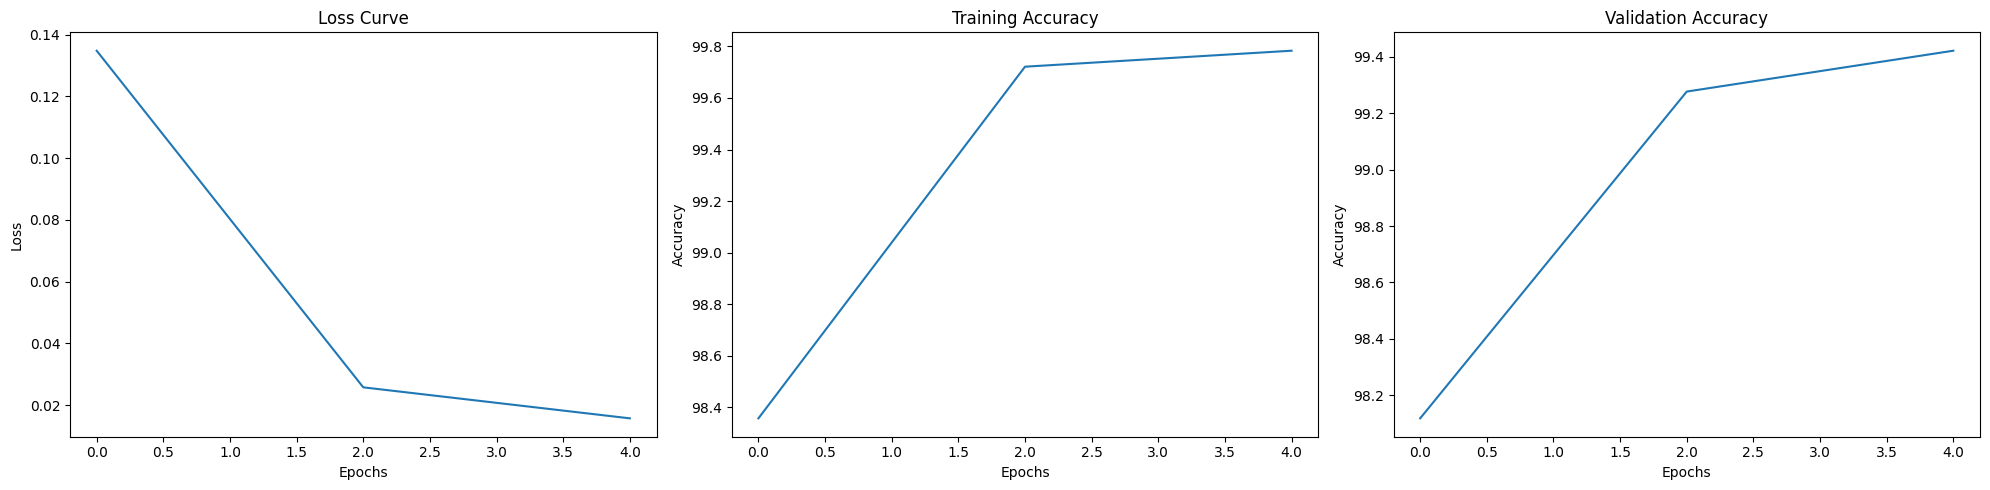

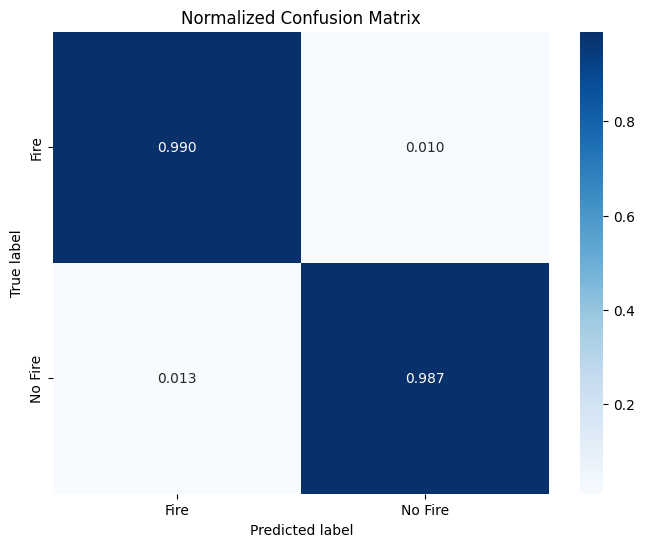

In [17]:
############################### Classifying using efficientnet  ###############################

model_name = "efficientnet"
num_classes = 2

# Flag for feature extracting. When False, we fine-tune the whole model,
# when True we only update the reshaped layer params
feature_extract = False
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
model_ft = model_ft.to(device)

calc_model_size_and_params(model_ft)

# Hyper Parameters
learning_rate = 0.001
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)


#train
train(model_ft, train_loader, val_loader, epochs, criterion, optimizer_ft, device, True)

#save model
torch.save(model_ft.state_dict(), f"{saved_models_path}/efficientnet_weights_with_fire.pth")


/==============================================================================/

resnet

/==============================================================================/

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 38.7MB/s]


num trainable weights:  11177538
model size: 42.68 MB


Epoch 0/5: 100%|██████████| 26/26 [06:34<00:00, 15.19s/batch, loss=0.134]


epoch: 0 loss: 0.13 train_score: 99.10 val score: 98.26


Epoch 2/5: 100%|██████████| 26/26 [00:36<00:00,  1.42s/batch, loss=0.0169]


epoch: 2 loss: 0.02 train_score: 99.91 val score: 99.57


Epoch 4/5: 100%|██████████| 26/26 [00:35<00:00,  1.38s/batch, loss=0.00672]


epoch: 4 loss: 0.01 train_score: 100.00 val score: 99.42


Epoch 5/5: 100%|██████████| 26/26 [00:34<00:00,  1.34s/batch, loss=0.00609]


test accuracy: 99.27745664739885
==> Finished Training ...
Training time: 757.7225124835968 [seconds]


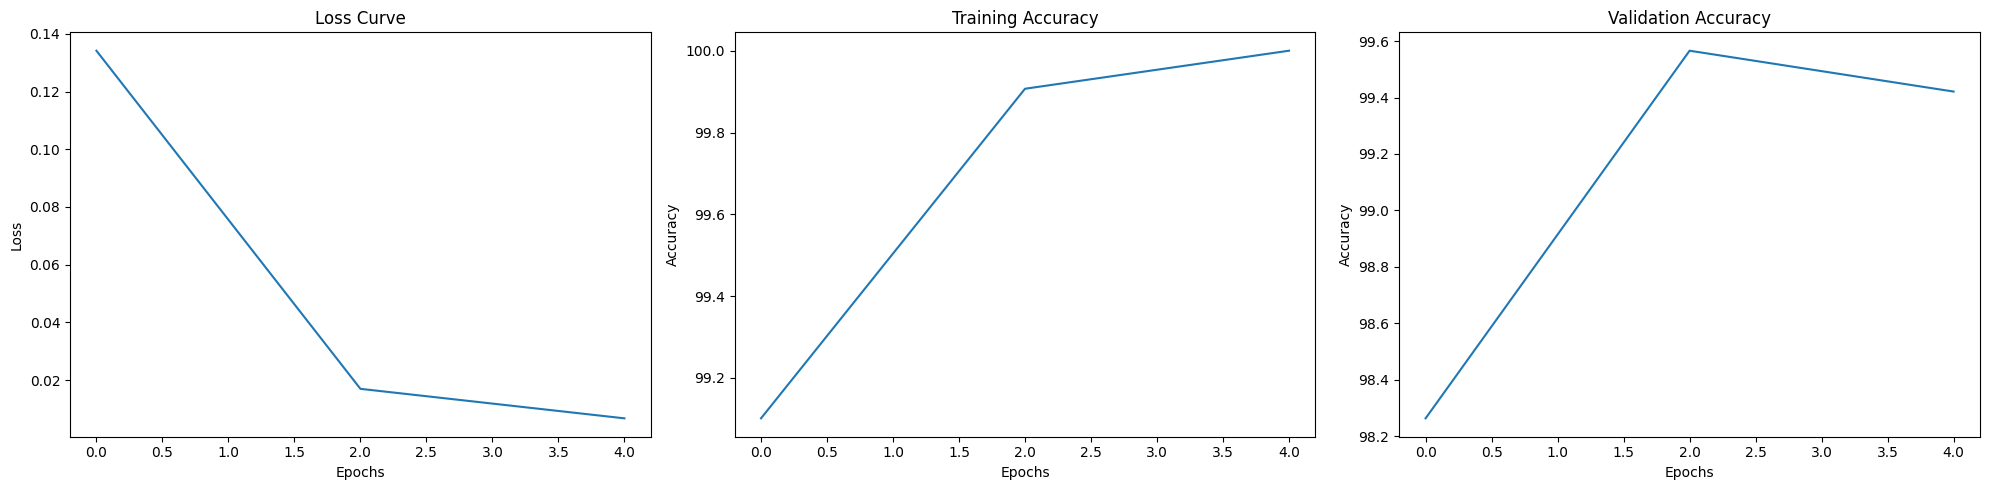

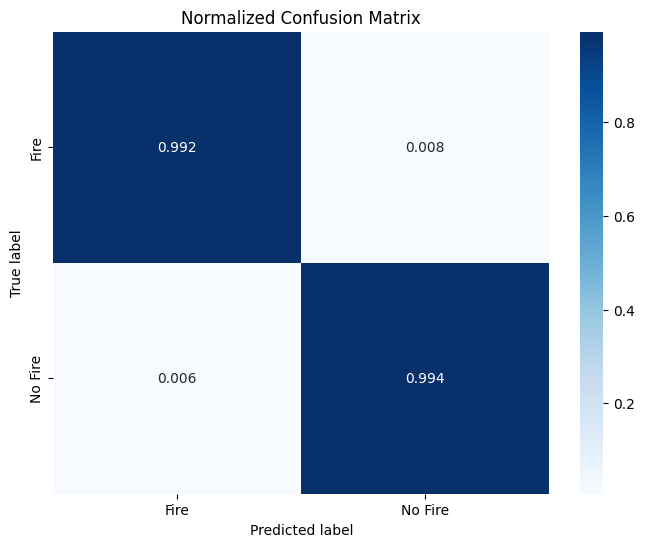

In [16]:
############################### Classifying using resnet  ###############################

model_name = "resnet"
num_classes = 2

# Flag for feature extracting. When False, we fine-tune the whole model,
# when True we only update the reshaped layer params
feature_extract = False
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft = model_ft.to(device)

calc_model_size_and_params(model_ft)

# Hyper Parameters
params_to_update = model_ft.parameters()
learning_rate=  0.0001
optimizer_ft = torch.optim.Adam(params_to_update, lr=learning_rate)
epochs = 5
criterion = nn.CrossEntropyLoss()

#train
train(model_ft, train_loader, val_loader, epochs, criterion, optimizer_ft, device, True)

#save model
torch.save(model_ft.state_dict(), f"{saved_models_path}/resnet_weights_with_fire.pth")